In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
#[url=https://www.pngarts.com/explore/190023/download/190022 Happy Doraemon PNG Image[/url]
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
device

device(type='cuda')

torch.Size([3, 1600, 1128])


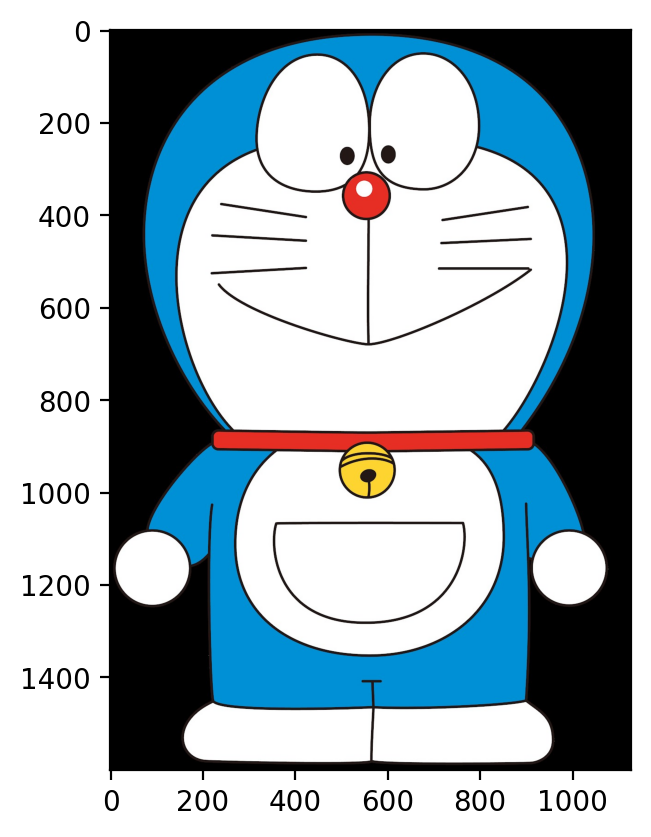

In [3]:
if os.path.exists("/content/abcd.jpg"):
  img = torchvision.io.read_image("/content/abcd.jpg")
print(img.shape)
img = img[:3,:,:]
plt.imshow(rearrange(img, 'b h w -> h w b').numpy())

In [4]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)) #converts to 1D array of 3*h*w 3 is channels
img_scaled = img_scaled.reshape(img.shape)
img_scaled = torch.tensor(img_scaled)

cropped_image = torchvision.transforms.functional.crop(img_scaled.cpu(), 1200, 400, 400, 400)
cropped_image.to(device)
cropped_image.shape

torch.Size([3, 400, 400])

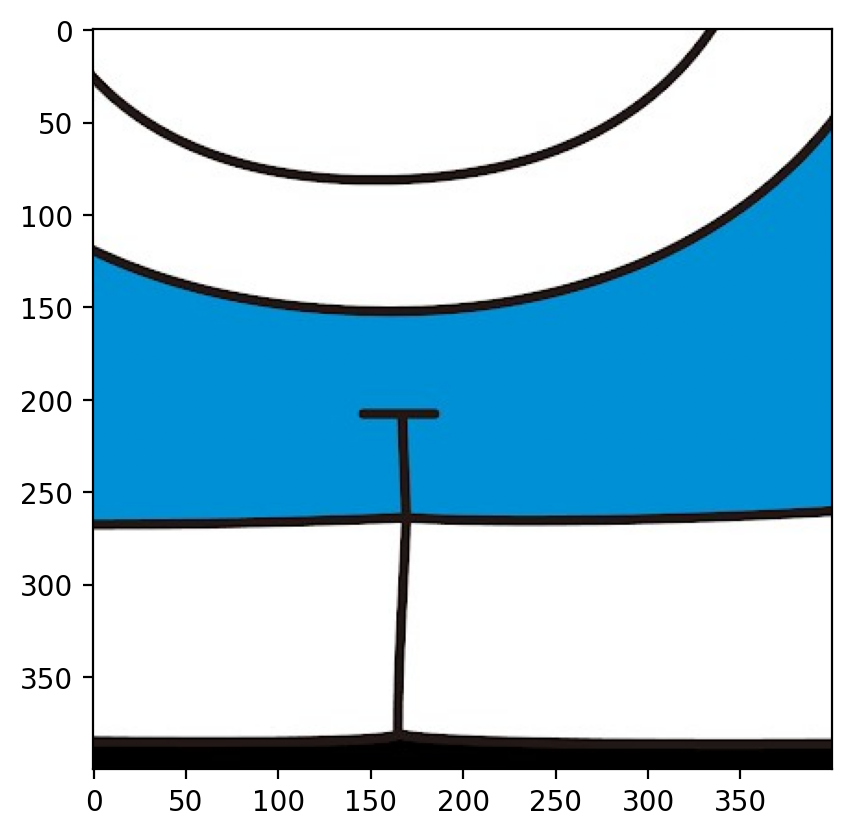

In [5]:
plt.imshow(rearrange(cropped_image, 'c h w -> h w c').cpu().numpy())

In [6]:
cropped_image.shape

torch.Size([3, 400, 400])

In [7]:
import cv2
import torch
img = cropped_image.permute(1, 2, 0).numpy()  # Change (C, H, W) to (H, W, C) for OpenCV

print('Original Dimensions : ', img.shape)

# Resize the image
scale_percent = 50  # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

# Resize the image
resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
print('Resized Dimensions : ', resized.shape)

Original Dimensions :  (400, 400, 3)
Resized Dimensions :  (200, 200, 3)


In [8]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).to(torch.float32)

    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').to(torch.float32)
    return X, Y

In [9]:
resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
# Note: OpenCV uses (H, W, C) format, so we need to permute to (C, H, W) for PyTorch
resized = torch.from_numpy(resized).permute(2, 0, 1)  # Change from (H, W, C) to (C, H, W)
resized = resized.to(device)
print(resized.shape)  # Check the shape of the tensor

torch.Size([3, 200, 200])


In [10]:
road_X, road_Y = create_coordinate_map(resized)
road_X_400, road_Y_400 = create_coordinate_map(cropped_image)
road_X.shape, road_Y.shape
road_Y = torch.tensor(road_Y).to(device)
road_Y_400 = torch.tensor(road_Y_400).to(device)

scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(road_X.cpu())  #road_X will work for GPU, but sklearn is for cpu
scaler_X_400 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(road_X_400.cpu())
road_X_scaled = scaler_X.transform(road_X.cpu())
road_X_scaled = torch.tensor(road_X_scaled).to(device)
road_X_400_scaled = scaler_X_400.transform(road_X_400.cpu())
road_X_400_scaled = torch.tensor(road_X_400_scaled).to(device)

# Set to dtype float32
road_X_scaled = road_X_scaled.to(torch.float32)
road_X_400_scaled = road_X_400_scaled.to(torch.float32)

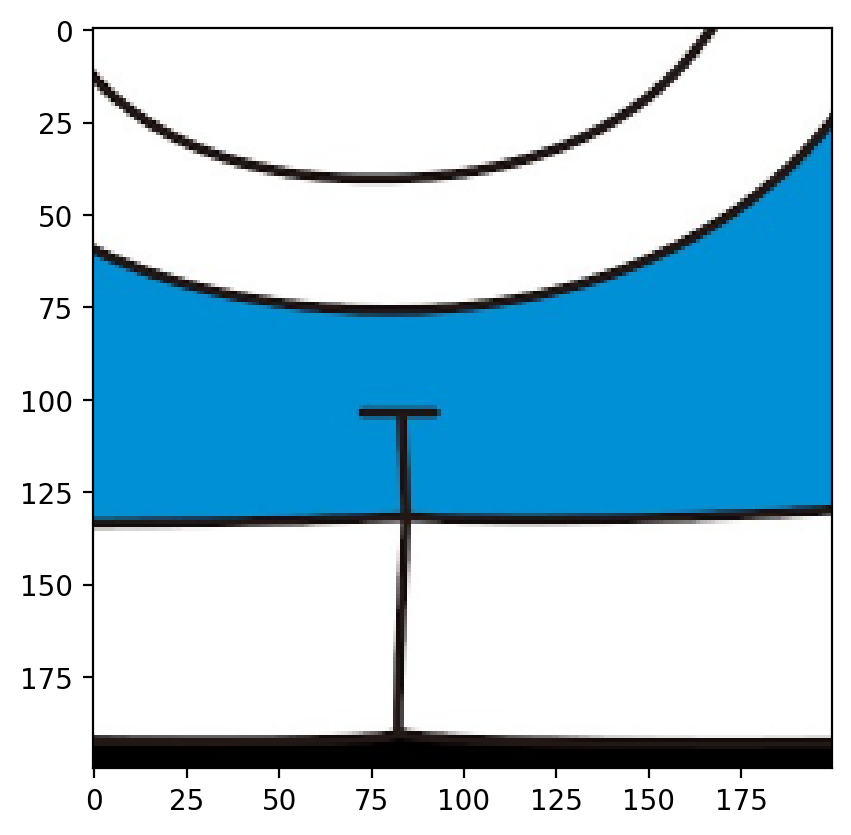

In [11]:
plt.imshow(rearrange(resized, 'c h w -> h w c').cpu().numpy())

In [12]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [13]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [14]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ##Now plotting for original image

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [15]:
def create_rff_features(X, num_features, sigma, device, batch_size=5000):
    n_samples, n_features = X.shape

    # Generate random weights and bias for RFF (weights can be large, so precompute and store on GPU)
    W = torch.randn(n_features, num_features, device=device) / sigma  # Random Gaussian weights
    b = 2 * torch.pi * torch.rand(num_features, device=device)  # Random bias

    Z_list = []  # Store the chunks of transformed data

    # Process the input in smaller batches to reduce memory usage
    for i in range(0, n_samples, batch_size):
        X_batch = X[i:i + batch_size]  # Slice the batch from the input tensor
        Z_batch = torch.matmul(X_batch, W) + b  # Linear transformation
        Z_batch = torch.cos(Z_batch) * (2.0 / torch.sqrt(torch.tensor(num_features, dtype=torch.float32, device=device)))  # Apply cosine and normalize
        Z_list.append(Z_batch)

    # Concatenate all the processed batches to form the final tensor
    Z = torch.cat(Z_list, dim=0)

    return Z

In [16]:
def create_rff_features_old(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [17]:
X_rff = create_rff_features_old(road_X_scaled, 4000, 0.005)

In [18]:
net = LinearModel(X_rff.shape[1], 3)    #same as 2, 3 only
net.to(device)

train(net, 0.005, X_rff, road_Y, 2500)

Epoch 0 loss: 0.688989
Epoch 100 loss: 0.225872
Epoch 200 loss: 0.127596
Epoch 300 loss: 0.114336
Epoch 400 loss: 0.111430
Epoch 500 loss: 0.109328
Epoch 600 loss: 0.107362
Epoch 700 loss: 0.105494
Epoch 800 loss: 0.103716
Epoch 900 loss: 0.102023
Epoch 1000 loss: 0.100410
Epoch 1100 loss: 0.098874
Epoch 1200 loss: 0.097411
Epoch 1300 loss: 0.096017
Epoch 1400 loss: 0.094690
Epoch 1500 loss: 0.093427
Epoch 1600 loss: 0.092226
Epoch 1700 loss: 0.091083
Epoch 1800 loss: 0.089998
Epoch 1900 loss: 0.088966
Epoch 2000 loss: 0.087987
Epoch 2100 loss: 0.087058
Epoch 2200 loss: 0.086178
Epoch 2300 loss: 0.085343
Epoch 2400 loss: 0.084552


0.08381069451570511

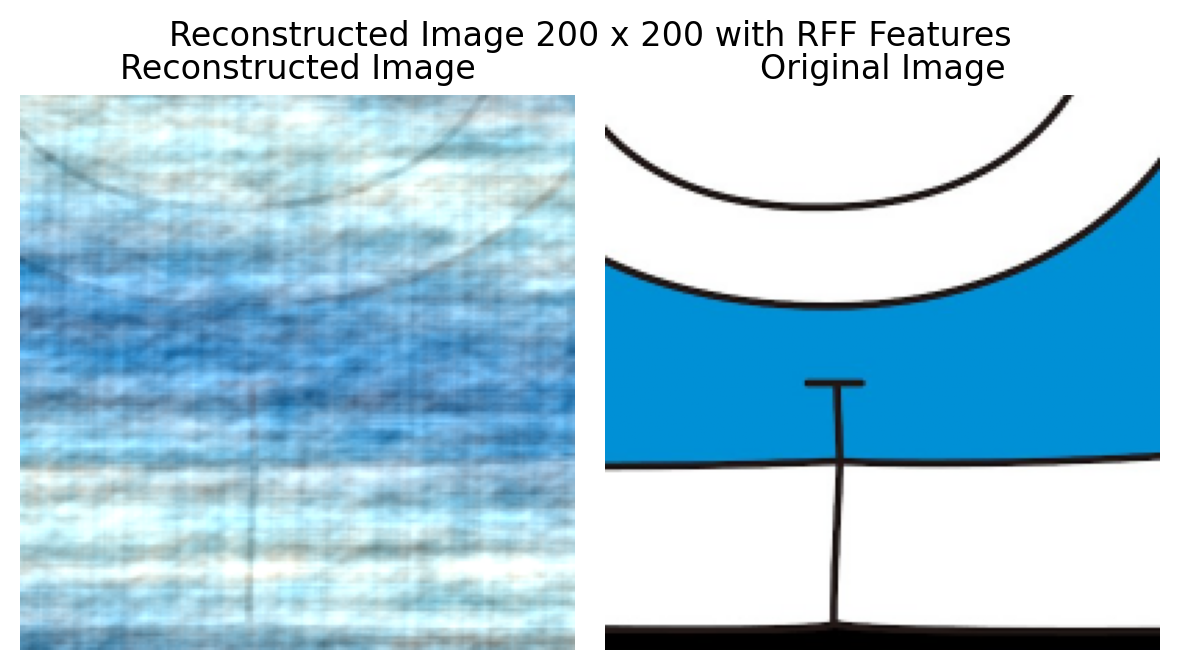

In [19]:
plot_reconstructed_and_original_image(resized, net, X_rff, title="Reconstructed Image 200 x 200 with RFF Features")

In [20]:
print(cropped_image.shape)
print(resized.shape)
print(X_rff.shape)

torch.Size([3, 400, 400])
torch.Size([3, 200, 200])
torch.Size([40000, 4000])


In [21]:
cropped_image.reshape((400,400,3)).to(device)

tensor([[[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        ...,

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.

In [22]:
def predict_image(cropped_image, resized_image, net, num_features, sigma):
    """
    Predicts the pixel values for the upsampled 400x400 image.

    Args:
        cropped_image: torch.Tensor of shape (3, 400, 400). Original high-resolution image.
        resized_image: torch.Tensor of shape (3, 200, 200). Downscaled image.
        net: torch.nn.Module. Trained linear regression model.
        num_features: int. Number of RFF features used during training.
        sigma: float. Kernel width parameter for the RBF kernel.

    Returns:
        torch.Tensor of shape (3, 400, 400). Final predicted 400x400 image.
    """
    # Ensure all tensors are on the same device as the model
    device = next(net.parameters()).device
    cropped_image = cropped_image.to(device)
    resized_image = resized_image.to(device)

    # Convert the resized image from torch.Tensor to numpy for OpenCV processing
    resized_image_np = resized_image.permute(1, 2, 0).cpu().numpy()  # Shape: (200, 200, 3)

    # Step 1: Upsample the 200x200 image to 400x400 using OpenCV's resize function
    upsampled_image_np = cv2.resize(resized_image_np, (400, 400), interpolation=cv2.INTER_LINEAR)

    # Step 2: Convert the upsampled image back to torch.Tensor and move to the correct device
    upsampled_image = torch.tensor(upsampled_image_np).permute(2, 0, 1).to(device)  # Shape: (3, 400, 400)

    # Step 3: Extract pixel values from the upsampled image for RFF feature extraction
    upsampled_pixels = upsampled_image.permute(1, 2, 0).view(-1, 3)  # Shape: (160000, 3)

    # Step 4: Create RFF features from the upsampled image's pixels
    rff_features = create_rff_features_old(upsampled_pixels, num_features, sigma)

    # Step 5: Use the trained model to predict pixel values
    predicted_pixels = net(rff_features)  # Shape: (160000, 3)

    # Step 6: Clamp predicted pixel values between 0 and 1
    predicted_pixels = predicted_pixels.clamp(min=0.0, max=1.0)  # Clamp values between 0 and 1

    # Step 7: Combine predicted pixel values with the upsampled image
    #combined_pixels = (upsampled_pixels + predicted_pixels)/2
    combined_pixels = predicted_pixels

    # Step 8: Reshape back to the original 400x400 image
    predicted_image = combined_pixels.view(400, 400, 3).permute(2, 0, 1)  # Shape: (3, 400, 400)

    return predicted_image


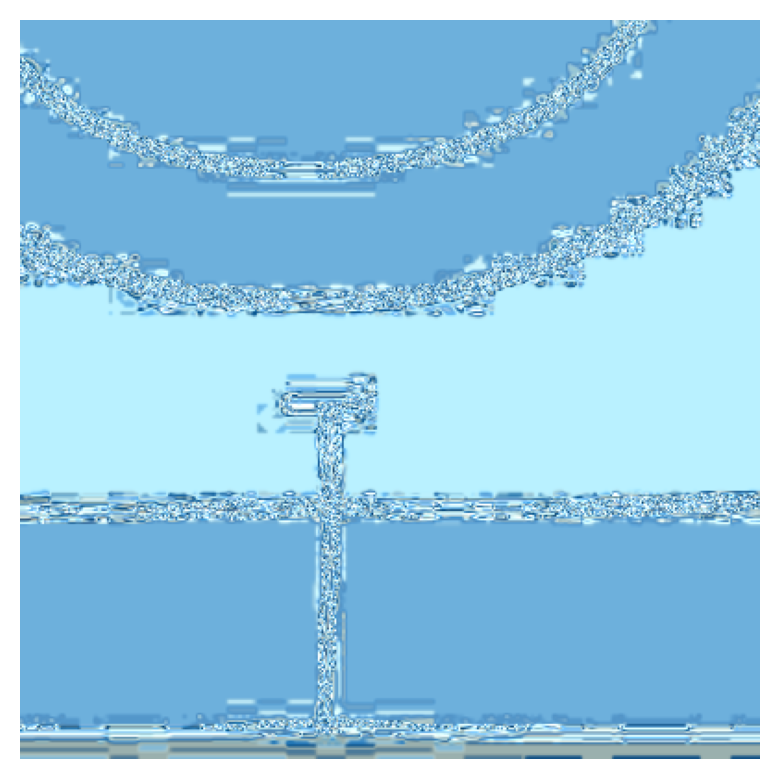

In [23]:
def display_image(tensor_image):
    """
    Displays the predicted image using matplotlib.

    Args:
        tensor_image: torch.Tensor of shape (3, 400, 400). The image to be displayed.
    """
    # Convert torch.Tensor to numpy array
    image_np = tensor_image.detach().permute(1, 2, 0).cpu().numpy()  # Shape: (400, 400, 3)

    # Clip the values to be between 0 and 1 for displaying
    image_np = image_np.clip(0, 1)  # Ensure brightness is properly normalized

    # Display the image using matplotlib
    plt.imshow(image_np)
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage after predicting the image
resized_image, num_features, sigma = resized, 4000, 0.005
predicted_image = predict_image(cropped_image.cpu(), resized_image.cpu(), net, num_features, sigma)
display_image(predicted_image)